In [1]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import datetime
import math
%matplotlib inline

In [2]:
# Load Microsoft stock price data set
df = pd.read_csv('MSFT.csv', parse_dates =['Date'], index_col ='Date', delimiter=',')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-05,111.010002,111.419998,108.099998,108.489998,106.811584,32872400
2018-09-06,108.250000,108.989998,107.510002,108.739998,107.057709,23477600
2018-09-07,108.230003,108.720001,107.230003,108.209999,106.535919,22498600
2018-09-10,108.839996,109.639999,108.360001,109.379997,107.687813,20727900
2018-09-11,108.900002,111.589996,108.889999,111.239998,109.519043,24301800


In [3]:
df.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [4]:
#Get independent variable Adj Close
df = df[['Adj Close']]

In [5]:
# A variable for predicting 'n' days out into the future
forecast_out = int(math.ceil(0.03 * len(df)))

#Create another column (dependent or target variable) shifted 'n' units up
df['Prediction'] = df[['Adj Close']].shift(-forecast_out)

In [7]:
# Create independent data set (X)
# Convert the dataframe to a numpy array
X = np.array(df.drop(['Prediction'], 1))

#Scale the features to normalize the data
X = preprocessing.scale(X)

# Remove the last 'n' rows
X = X[:-forecast_out]

In [8]:
# Create the dependent data set (y)
# Convert the dataframe to numpy array
y = np.array(df['Prediction'])

# Get all y values except 'n' rows
y = y[:-forecast_out]

In [9]:
# Split data set into 80% training and 20% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# Create and train Linear, quadratic and polynomial regression models

# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Quadratic Regression 2
reg_poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
reg_poly2.fit(X_train, y_train)

# Quadratic Regression 3
reg_poly3 = make_pipeline(PolynomialFeatures(3), Ridge())
reg_poly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [11]:
# Create and train Support Vector Machine (Regressor) model

svr_rbf = SVR(kernel = 'rbf', C=1e3, gamma = 0.1)
svr_rbf.fit(X_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
# Model Evaluation: score returns the confidence of determination R^2 of the prediction.

confidence_lr = lr.score(X_test, y_test)
confidence_reg_poly2 = reg_poly2.score(X_test,y_test)
confidence_reg_poly3 = reg_poly3.score(X_test,y_test)
confidence_svm = svr_rbf.score(X_test, y_test)

print('The linear regression confidence is: ', confidence_lr)
print('The quadratic regression 2 confidence is: ', confidence_reg_poly2)
print('The quadratic regression 3 confidence is : ', confidence_reg_poly3)
print('The svm confidence is: ', confidence_svm)

The linear regression confidence is:  0.8742186725679312
The quadratic regression 2 confidence is:  0.8735900280066793
The quadratic regression 3 confidence is :  0.8810159368217841
The svm confidence is:  0.8758021405002601


In [13]:
# Set x_forecast equal to the last 'n' rows of the original data set from the Adj Close column
x_forecast = np.array(df.drop(['Prediction'], 1))[-forecast_out:]

In [14]:
# Print model predictions for the next 'n' days

lr_prediction = lr.predict(x_forecast)
reg_poly2_prediction = reg_poly2.predict(x_forecast)
reg_poly3_prediction = reg_poly3.predict(x_forecast)
svm_prediction = svr_rbf.predict(x_forecast)

print('The linear regression prediction is: ', lr_prediction)
print('The quadratic regression 2 prediction is: ', reg_poly2_prediction)
print('The quadratic regression 3 prediction is : ', reg_poly3_prediction)
print('The svm prediction is: ', svm_prediction)

The linear regression prediction is:  [1842.12610916 1845.8162858  1843.52580545 1876.10022102 1872.79195441
 1849.6334519  1869.86539423 1900.65840708]
The quadratic regression 2 prediction is:  [-471.65994631 -477.88031786 -474.01686093 -529.7287077  -523.99530814
 -484.33703407 -518.93761472 -572.82149417]
The quadratic regression 3 prediction is :  [-4616693.98538445 -4646435.03139614 -4627959.87958201 -4895347.80497229
 -4867733.97964265 -4677333.64092601 -4843392.94294987 -5103604.34230897]
The svm prediction is:  [113.27256325 113.27256325 113.27256325 113.27256325 113.27256325
 113.27256325 113.27256325 113.27256325]


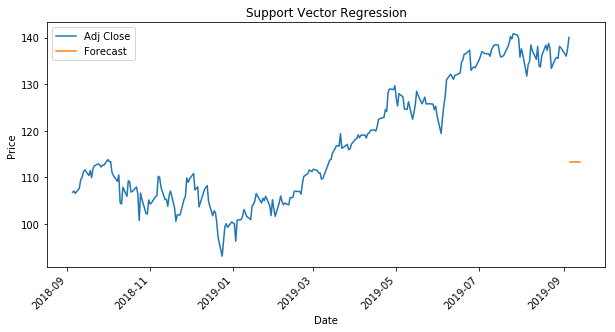

In [16]:
# Visualize predictions

forecast_set = svr_rbf.predict(x_forecast)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

plt.figure(figsize=(10, 5))
df['Adj Close'].plot()
df['Forecast'].plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.title('Support Vector Regression')
plt.show()